In [185]:
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
X = pd.read_pickle('Data/X.pkl')
y = pd.read_pickle('Data/y.pkl')

In [3]:
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.70, shuffle=False)
# this order is not a mistake - I want my train set to be located earlier in time that test

In [4]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

In [5]:
display(X_val.iloc[[0,-1]])

display(X_test.iloc[[0,-1]])

display(X_train.iloc[[0,-1]])

,gas_daily_change,gas_volatility,gas_daily_gap,rate_2y_daily_change,SP500_daily_change,WTI_daily_change,EurUsd,TTF_daily_change,Storage,GDP_quarterly_change,US_temp,Friday,Monday,Thursday,Tuesday,Wednesday,filling,gas_daily_change_lag22
Date,,,,,,,,,,,,,,,,,,
2020-03-12,-0.019702,0.072243,0.002662,0.00000,-0.095113,-0.044876,1.1240,-0.004803,2043.0,0.005197,75.360065,0,0,1,0,0,True,0.012458
2018-09-10,0.010086,0.022111,-0.002161,0.00738,0.001898,-0.003100,1.1571,0.040587,2567.0,0.005423,-85.799000,0,1,0,0,0,False,0.002035


,gas_daily_change,gas_volatility,gas_daily_gap,rate_2y_daily_change,SP500_daily_change,WTI_daily_change,EurUsd,TTF_daily_change,Storage,GDP_quarterly_change,US_temp,Friday,Monday,Thursday,Tuesday,Wednesday,filling,gas_daily_change_lag22
Date,,,,,,,,,,,,,,,,,,
2018-09-07,0.001443,0.009366,0.001804,0.026515,-0.002213,-0.000295,1.1615,0.019487,2567.0,0.005423,-85.799000,1,0,0,0,0,False,0.017950
2017-03-06,0.026176,0.032747,0.029713,-0.007576,-0.003277,-0.002438,1.0592,-0.009066,2363.0,0.005423,75.360065,0,1,0,0,0,True,0.005997


,gas_daily_change,gas_volatility,gas_daily_gap,rate_2y_daily_change,SP500_daily_change,WTI_daily_change,EurUsd,TTF_daily_change,Storage,GDP_quarterly_change,US_temp,Friday,Monday,Thursday,Tuesday,Wednesday,filling,gas_daily_change_lag22
Date,,,,,,,,,,,,,,,,,,
2017-03-03,0.008203,0.022993,0.004280,0.000000,0.000504,0.013686,1.0565,0.000358,2363.0,0.005423,75.360065,1,0,0,0,0,True,0.016362
2010-02-04,-0.000554,0.050406,-0.002399,-0.090909,-0.031141,-0.049883,1.3847,0.000000,2406.0,0.010984,126.992186,0,0,1,0,0,True,0.055994


In [6]:
pd.concat([X_train, y_train], axis=1, sort=False)

,gas_daily_change,gas_volatility,gas_daily_gap,rate_2y_daily_change,SP500_daily_change,WTI_daily_change,EurUsd,TTF_daily_change,Storage,GDP_quarterly_change,US_temp,Friday,Monday,Thursday,Tuesday,Wednesday,filling,gas_daily_change_lag22,gas_target
Date,,,,,,,,,,,,,,,,,,,
2017-03-03,0.008203,0.022993,0.004280,0.000000,0.000504,0.013686,1.0565,0.000358,2363.0,0.005423,75.360065,1,0,0,0,0,True,0.016362,1.0
2017-03-02,0.001786,0.037447,-0.002858,0.023256,-0.005860,-0.022664,1.0514,-0.020570,2363.0,0.005423,75.360065,0,0,1,0,0,True,-0.035582,1.0
2017-03-01,0.009012,0.030368,-0.001442,0.057377,0.013674,-0.003333,1.0533,0.012784,2356.0,0.005423,75.360065,0,0,0,0,1,True,-0.046889,1.0
2017-02-28,0.030078,0.048666,-0.000743,0.016667,-0.002578,-0.000740,1.0597,-0.019442,2356.0,0.005423,126.992186,0,0,0,1,0,True,0.002661,1.0
2017-02-27,0.025124,0.023023,0.033498,0.071429,0.001018,0.001111,1.0587,-0.031858,2356.0,0.005423,126.992186,0,1,0,0,0,True,0.015006,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-02-10,0.000378,0.026455,0.010964,0.083333,-0.002233,0.010441,1.3740,0.000000,2406.0,0.010984,126.992186,0,0,0,0,1,True,-0.051313,1.0
2010-02-09,-0.020552,0.038563,0.003518,0.063291,0.013040,0.025873,1.3760,0.000000,2406.0,0.010984,126.992186,0,0,0,1,0,True,-0.009817,1.0
2010-02-08,-0.020671,0.052583,0.015775,0.025974,-0.008863,0.009833,1.3675,0.000000,2406.0,0.010984,126.992186,0,1,0,0,0,True,-0.033783,0.0


In [7]:
# sns.pairplot(pd.concat([X_train, y_train], axis=1, sort=False), hue="gas_target")
# plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001AF8C6DBE58> (for post_execute):


KeyboardInterrupt: 

Balance of the classes

In [8]:
y_train.value_counts()

0.0    900
1.0    877
Name: gas_target, dtype: int64

In [9]:
# # preparing steps for the pipeline
# steps = [('polynomial', PolynomialFeatures(2,include_bias=False)),
#          ('Yeo-Johnson', PowerTransformer())]

In [10]:
# pipeline = Pipeline(steps)

In [11]:
# X_train_transf = pd.DataFrame(pipeline.fit_transform(X_train), index = X_train.index)
# X_train_transf.head()

In [12]:
# X_train_transf.shape

In [13]:
# display(X_train.describe()[1:3].round(2))
# # display(X_train_transf_BC.describe()[1:3].round(2))
# display(X_train_transf.describe()[1:3].round(2))

In [14]:
# selector = RFE(LogisticRegression(solver='lbfgs', max_iter=300, n_jobs=-1), 10, 2)

In [15]:
# selector.fit(X_train_transf, y_train)
# selected_columns = selector.get_support(indices=True)
# selected_columns

In [16]:
# selector

In [17]:
# X_train_transf.iloc[:, selected_columns]

### Logistic Regression

In [124]:
steps = [('MinMaxScaler', MinMaxScaler()),
         ('Polynomial', PolynomialFeatures(3, include_bias=False)),
         ('Yeo-Johnson', PowerTransformer()),
         ('RFE', RFE(LogisticRegression(solver='lbfgs', max_iter=300, n_jobs=-1), 50, 10))]
#          ('PCA', PCA(n_components=12))]

In [125]:
# pipeline = Pipeline(steps)

# params = {}
# params['LogReg__C'] = [0.1, 0.5, 1]

# CV = GridSearchCV(pipeline, params, n_jobs=-1, verbose=1)

# CV.fit(X_train, y_train)

In [126]:
pipeline = Pipeline(steps)
X_train_transf = pd.DataFrame(pipeline.fit_transform(X_train, y_train), index = X_train.index)
X_train_transf.head()

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-03,0.277126,0.859836,-0.942623,0.565728,-0.977105,-0.819822,-0.437024,0.773403,0.517662,1.139085,...,1.042422,-0.455295,0.572140,-0.495941,0.411355,-0.442432,2.427231,-0.442562,-0.436960,-0.461760
2017-03-02,-0.287487,0.779608,0.126714,-1.656292,0.162523,-0.195367,-0.359568,-0.950811,0.462533,1.090191,...,-0.453308,-0.455295,-0.493794,-0.495941,0.230806,-0.442432,-0.436796,-0.442562,-0.436960,-0.461760
2017-03-01,1.073095,0.869852,-0.371374,-1.263609,-0.355574,-0.444064,-0.953962,0.039558,0.518832,1.145066,...,-0.453308,-0.455295,-0.493794,-0.495941,0.505672,2.402762,-0.436796,2.334594,-0.436960,-0.461760
2017-02-28,0.663079,1.549598,0.816635,-0.445843,1.254284,0.558967,1.318707,0.469135,0.956622,1.491220,...,-0.453308,1.405881,-0.493794,0.602258,0.489333,-0.442432,-0.436796,-0.442562,-0.436960,2.343207
2017-02-27,0.770780,1.485484,-0.500043,-0.510038,-0.870617,-0.684615,-0.209127,0.484133,0.917511,1.463324,...,-0.453308,-0.455295,-0.493794,-0.495941,0.364682,-0.442432,-0.436796,-0.442562,2.458787,-0.461760


In [127]:
# Printing some statistics to evaluate the models performance
def evaluate(y_true, y_pred):
      
    print ('''Accuracy:
    ''',
    accuracy_score(y_true,y_pred)*100)
    
    c_m = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(c_m, annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    
    print('''
    --------------------------------------------------
    ''')

In [128]:
model = LogisticRegression()
model.fit(X_train_transf, y_train)

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy:
     58.46933033202026


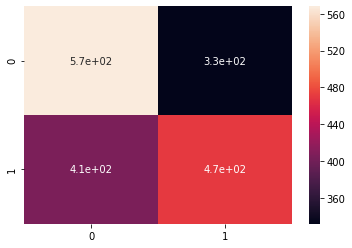


    --------------------------------------------------
    


In [129]:
y_pred = model.predict(X_train_transf)
evaluate(y_train, y_pred)

In [130]:
X_test_transf = pd.DataFrame(pipeline.transform(X_test), index = X_test.index)
X_test_transf

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Date,,,,,,,,,,,,,,,,,,,,,
2018-09-07,-0.074973,-0.724904,-2.652549,1.174638,-1.849494,-1.586212,-2.161380,0.057215,-0.615030,-0.189996,...,1.629452,-0.455295,2.059658,-0.495941,-0.571829,-0.442432,2.427600,-0.442562,-0.436960,-0.461760
2018-09-06,-0.429134,-0.773184,-2.368488,0.923373,-1.773698,-1.489253,-2.009026,-0.694938,-0.659672,-0.243660,...,-0.453308,-0.455295,-0.493794,-0.495941,-0.585301,-0.442432,-0.436796,-0.442562,-0.436960,-0.461760
2018-09-05,-0.427868,-0.781667,-1.325714,0.461855,-1.274579,-1.011901,-1.165560,-0.835132,-0.689348,-0.253177,...,-0.453308,-0.455295,-0.493794,-0.495941,-0.627315,2.410543,-0.436796,2.399202,-0.436960,-0.461760
2018-09-04,-1.012772,-0.893373,-0.269736,0.984129,-0.581951,-0.669235,-0.417507,-0.476059,-0.790905,-0.380942,...,-0.453308,1.577202,-0.493794,2.017626,-0.601948,-0.442432,-0.436796,-0.442562,-0.436960,2.057525
2018-08-31,0.430990,-1.349458,-1.627731,0.247374,-1.409473,-1.032916,-0.954564,-0.018511,-1.220282,-0.950937,...,0.045592,-0.455295,2.076684,-0.495941,-1.241227,-0.442432,2.428258,-0.442562,-0.436960,-0.461760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-10,0.535727,0.899646,-0.687672,0.068757,-0.741746,-0.713337,-0.418653,-0.515947,0.488675,1.162699,...,1.234053,-0.455295,0.625434,-0.495941,0.367189,-0.442432,2.421266,-0.442562,-0.436960,-0.461760
2017-03-09,0.757741,1.064741,0.005916,0.599170,0.100856,-0.177747,0.831054,-0.523867,0.597983,1.256141,...,-0.453308,-0.455295,-0.493794,-0.495941,0.289650,-0.442432,-0.436796,-0.442562,-0.436960,-0.461760
2017-03-08,0.610544,1.089444,0.412110,-0.533131,0.623290,0.189073,0.768872,-2.097636,0.671605,1.269513,...,-0.453308,-0.455295,-0.493794,-0.495941,0.274800,2.403212,-0.436796,2.395725,-0.436960,-0.461760


LogisticRegression
Accuracy:
     48.031496062992126


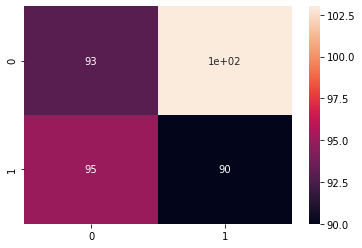


    --------------------------------------------------
    


In [131]:
y_pred = model.predict(X_test_transf)

print(model.__class__.__name__)
evaluate(y_test, y_pred)

### Decision Tree

In [29]:
steps = [('MinMaxScaler', MinMaxScaler()),
         ('Polynomial', PolynomialFeatures(2, include_bias=False)),
         ('Yeo-Johnson', PowerTransformer()),
         ('RFE', RFE(DecisionTreeClassifier(max_depth=10, min_samples_leaf=25), 50, 2)),
         ('PCA', PCA(n_components=12))]

In [30]:
pipeline = Pipeline(steps)
X_train_transf = pd.DataFrame(pipeline.fit_transform(X_train, y_train), index = X_train.index)
X_train_transf.head()

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


,0,1,2,3,4,5,6,7,8,9,10,11
Date,,,,,,,,,,,,
2017-03-03,-0.517985,2.276595,-0.721705,-1.527241,-1.013708,3.747219,0.396937,-1.205020,-0.345010,1.376569,-0.783808,0.248301
2017-03-02,2.602077,-2.317978,-2.209727,1.594583,-2.378145,-0.674559,0.442638,1.772711,1.095780,-0.440287,-0.528882,1.747053
2017-03-01,-0.453308,1.730954,-1.259674,-1.273511,1.451174,-1.797918,2.776923,2.250021,-0.639117,-1.570809,-1.666872,0.136990
2017-02-28,-1.171669,-0.904526,-0.589586,-0.264062,-1.743409,-0.530303,1.453861,-0.406466,-1.265142,-0.617119,3.102769,1.196665
2017-02-27,-0.485708,1.589988,4.125468,-0.821230,-2.344035,-0.969166,0.769534,-0.195011,0.938944,-1.015932,-0.761786,0.977110


In [31]:
model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=25)
model.fit(X_train_transf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Accuracy:
     64.04051772650534


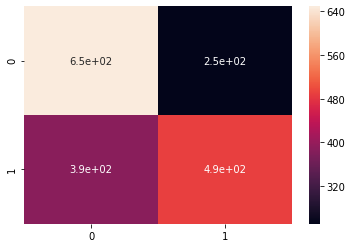


    --------------------------------------------------
    


In [32]:
y_pred = model.predict(X_train_transf)
evaluate(y_train, y_pred)

In [33]:
X_test_transf = pd.DataFrame(pipeline.transform(X_test), index = X_test.index)
X_test_transf

,0,1,2,3,4,5,6,7,8,9,10,11
Date,,,,,,,,,,,,
2018-09-07,1.866115,4.935654,-0.305392,-0.778739,0.343058,2.665830,-2.856884,-0.714544,1.000540,0.209857,-0.967450,-0.469575
2018-09-06,2.753197,2.310167,-1.430968,2.210026,0.000585,0.467509,-3.095332,0.059002,3.892808,-0.328575,-1.204014,-0.182674
2018-09-05,2.785709,2.500064,-1.358839,-0.831928,2.511852,-2.054029,-0.455469,-0.595875,0.339309,-0.193596,-1.009849,-0.213905
2018-09-04,1.361778,0.196893,-0.162416,1.340058,1.928838,0.985515,-0.910196,-0.698902,-0.661931,-0.790349,2.082458,-1.468865
2018-08-31,1.678339,3.435265,-0.533303,-0.542473,-0.292132,1.838062,-2.758649,-0.920813,-0.654615,0.077779,-0.640716,1.060283
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-10,0.791998,1.562123,-1.174116,-1.971882,-2.161679,2.898958,0.324764,-1.081248,-0.946188,-0.223175,-1.675065,0.085022
2017-03-09,-0.748105,-0.801333,-1.794944,1.860098,-2.389476,-0.776672,-0.352218,-1.257176,1.917849,-0.821220,-0.753110,1.254421
2017-03-08,2.183787,-0.498175,-2.310037,-2.535422,-1.195983,-4.191238,1.453217,-1.414955,-1.119490,-2.234923,-1.389375,1.508332


DecisionTreeClassifier
Accuracy:
     53.54330708661418


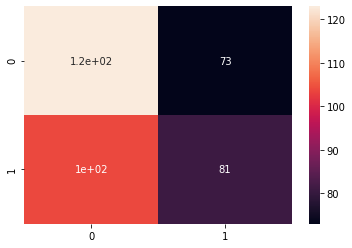


    --------------------------------------------------
    


In [34]:
y_pred = model.predict(X_test_transf)

print(model.__class__.__name__)
evaluate(y_test, y_pred)

### Naive Bayes

In [72]:
steps = [('MinMaxScaler', MinMaxScaler()),
         ('Polynomial', PolynomialFeatures(2, include_bias=False)),
         ('Yeo-Johnson', PowerTransformer()),
#          ('RFE', RFE(GaussianNB(), 50, 2)),
         ('PCA', PCA(n_components=12))]

In [73]:
pipeline = Pipeline(steps)
X_train_transf = pd.DataFrame(pipeline.fit_transform(X_train, y_train), index = X_train.index)
X_train_transf.head()

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


,0,1,2,3,4,5,6,7,8,9,10,11
Date,,,,,,,,,,,,
2017-03-03,3.032400,-5.438822,-4.315432,-4.482277,-4.007361,0.691911,-0.240691,5.244737,3.526787,0.033016,1.203973,3.320053
2017-03-02,4.360958,6.564132,-1.735345,-0.374280,-1.568475,0.786333,6.405605,4.139099,3.863080,-0.752699,3.020633,-0.107031
2017-03-01,3.865881,-3.706284,-0.642354,7.961770,-0.651243,0.351664,0.820628,5.273778,3.086047,1.401391,4.493796,-1.474755
2017-02-28,5.681029,-1.504442,8.106031,-2.197836,-0.428777,0.525447,1.929746,5.856382,-0.635257,-0.613031,2.258402,2.319573
2017-02-27,4.299044,-1.756380,-1.645660,-1.502015,8.183599,1.534226,-2.281684,5.047484,4.440904,-2.257220,2.143634,3.701798


In [74]:
model = GaussianNB()
model.fit(X_train_transf, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Accuracy:
     53.742262239729875


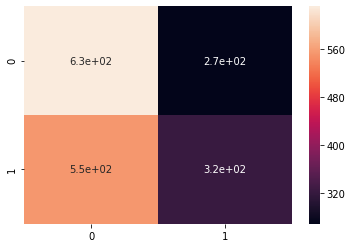


    --------------------------------------------------
    


In [75]:
y_pred = model.predict(X_train_transf)
evaluate(y_train, y_pred)

In [76]:
X_test_transf = pd.DataFrame(pipeline.transform(X_test), index = X_test.index)
X_test_transf

,0,1,2,3,4,5,6,7,8,9,10,11
Date,,,,,,,,,,,,
2018-09-07,-6.172468,-5.005314,-3.961117,-4.164544,-4.042709,-0.826238,-1.022200,1.740695,5.756113,-0.468089,-0.925546,2.126325
2018-09-06,-5.008288,6.174333,-1.339411,0.003693,-2.207033,-0.118439,2.498798,0.542992,7.735630,-1.690044,-1.090140,2.084686
2018-09-05,-5.249086,-2.747280,-0.798258,7.683801,-0.653066,-1.467402,2.425474,1.956469,2.429396,-0.005229,-0.561086,1.159834
2018-09-04,-4.087124,-0.323760,7.855027,-1.933765,-0.458133,-1.457339,1.339909,2.722461,0.516455,2.628389,-1.247489,0.928704
2018-08-31,-6.822784,-4.025227,-3.897811,-4.155873,-3.883804,-1.618853,0.015662,2.042257,2.715943,-0.950833,-0.449239,2.417215
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-10,2.841824,-5.370707,-4.501141,-4.646339,-3.797664,0.525146,1.845935,4.987261,2.427009,-0.701394,1.573206,2.536821
2017-03-09,4.820104,6.769391,-1.372500,-0.100049,-2.270298,1.344226,2.156973,4.721866,3.857673,-2.134361,0.613428,4.157509
2017-03-08,3.653155,-3.286079,-1.027124,7.587818,-0.283547,-0.400995,5.140487,5.222640,-0.544710,-2.231798,0.798599,2.089885


GaussianNB
Accuracy:
     50.91863517060368


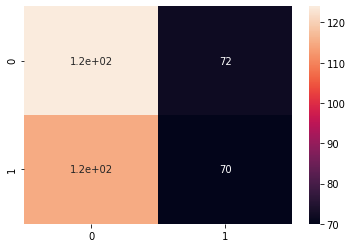


    --------------------------------------------------
    


In [77]:
y_pred = model.predict(X_test_transf)

print(model.__class__.__name__)
evaluate(y_test, y_pred)

### K-Nearest Neighbours

In [78]:
steps = [('MinMaxScaler', MinMaxScaler()),
         ('Polynomial', PolynomialFeatures(2, include_bias=False)),
         ('Yeo-Johnson', PowerTransformer()),
#          ('RFE', RFE(KNeighborsClassifier(n_neighbors=10), 50, 2)),
         ('PCA', PCA(n_components=12))]

In [79]:
pipeline = Pipeline(steps)
X_train_transf = pd.DataFrame(pipeline.fit_transform(X_train, y_train), index = X_train.index)
X_train_transf.head()

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


,0,1,2,3,4,5,6,7,8,9,10,11
Date,,,,,,,,,,,,
2017-03-03,0.632395,0.069043,0.080973,0.057506,0.122302,0.481013,0.486147,0.815613,0.628358,0.484451,0.543684,0.659321
2017-03-02,0.701754,0.776837,0.256527,0.351060,0.268866,0.486264,0.692319,0.743666,0.644756,0.458625,0.624903,0.476364
2017-03-01,0.675908,0.171208,0.330897,0.946746,0.323987,0.462090,0.519070,0.817502,0.606866,0.529429,0.690766,0.403347
2017-02-28,0.770669,0.301047,0.926156,0.220750,0.337356,0.471755,0.553475,0.855414,0.425409,0.463216,0.590825,0.605910
2017-02-27,0.698522,0.286191,0.262630,0.270473,0.854913,0.527859,0.422835,0.802777,0.672932,0.409172,0.585694,0.679700


In [80]:
model = KNeighborsClassifier(n_neighbors=20)
model.fit(X_train_transf, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

Accuracy:
     58.300506471581315


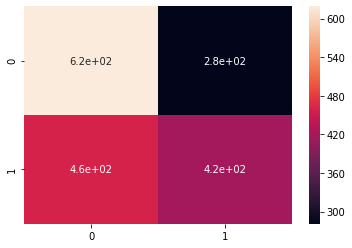


    --------------------------------------------------
    


In [81]:
y_pred = model.predict(X_train_transf)
evaluate(y_train, y_pred)

In [82]:
X_test_transf = pd.DataFrame(pipeline.transform(X_test), index = X_test.index)
X_test_transf

,0,1,2,3,4,5,6,7,8,9,10,11
Date,,,,,,,,,,,,
2018-09-07,0.151847,0.094607,0.105081,0.080211,0.120178,0.396579,0.461905,0.587596,0.737064,0.467980,0.448477,0.595593
2018-09-06,0.212624,0.753851,0.283468,0.378069,0.230492,0.435944,0.571128,0.509659,0.833589,0.427815,0.441118,0.593370
2018-09-05,0.200053,0.227759,0.320289,0.926882,0.323877,0.360920,0.568853,0.601637,0.574847,0.483194,0.464771,0.543996
2018-09-04,0.260714,0.370670,0.909077,0.239620,0.335592,0.361479,0.535178,0.651482,0.481568,0.569760,0.434083,0.531657
2018-08-31,0.117897,0.152401,0.109388,0.080831,0.129728,0.352496,0.494100,0.607220,0.588819,0.452112,0.469771,0.611122
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-10,0.622446,0.073060,0.068337,0.045782,0.134904,0.471738,0.550876,0.798858,0.574730,0.460311,0.560191,0.617507
2017-03-09,0.725724,0.788941,0.281216,0.370656,0.226690,0.517292,0.560524,0.781588,0.644492,0.413210,0.517281,0.704029
2017-03-08,0.664802,0.195987,0.304716,0.920023,0.346083,0.420229,0.653074,0.814175,0.429824,0.410008,0.525560,0.593647


KNeighborsClassifier
Accuracy:
     52.493438320209975


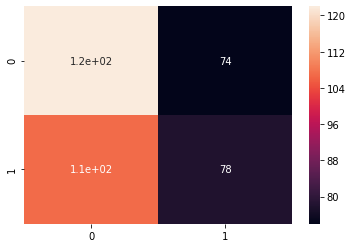


    --------------------------------------------------
    


In [83]:
y_pred = model.predict(X_test_transf)

print(model.__class__.__name__)
evaluate(y_test, y_pred)

### Pipeline all-in-one

In [169]:
Polynomial__degree = [1, 2]
RFE__n_features_to_select = [150, 100, 50, 25, 10]
PCA__n_components = [10, 50, 100]
DecisionTree__max_depth = [5, 20, 35]
Accuracy = -1

for P_d in Polynomial__degree:
    for n_f in RFE__n_features_to_select:
        for n_c in PCA__n_components:
            for m_d in DecisionTree__max_depth:
                
                steps = [('MinMaxScaler', MinMaxScaler(feature_range=(0.1, 1.1))),
                         ('Polynomial', PolynomialFeatures(degree=P_d, include_bias=False)),
                         ('Yeo-Johnson', PowerTransformer()),
                         ('RFE', RFE(DecisionTreeClassifier(max_depth=10, min_samples_leaf=25), n_features_to_select=n_f, step=5)),
                         ('PCA', PCA(n_components=min(X_train_transf.shape[1], n_c)))]
                
                pipeline = Pipeline(steps)
                
                X_train_transf = pd.DataFrame(pipeline.fit_transform(X_train, y_train), index = X_train.index)
                X_test_transf = pd.DataFrame(pipeline.transform(X_test), index = X_test.index)
                
                model = DecisionTreeClassifier(max_depth=m_d, min_samples_leaf=25)
                model.fit(X_train_transf, y_train)

                y_pred = model.predict(X_test_transf)
                
                print(round(accuracy_score(y_test,y_pred)*100, 2), P_d, n_f, min(X_train_transf.shape[1], n_c), m_d)

                if accuracy_score(y_test,y_pred)*100 > Accuracy:
                    Accuracy = accuracy_score(y_test,y_pred)*100
                    poly_degree = P_d
                    n_features = n_f
                    n_components = min(X_train_transf.shape[1], n_c)
                    maxdepth = m_d
                    DecTreePred = y_pred
                    
print(f'''
-----------------------------------------
The best combination is: 
accuracy - {Accuracy} 
polynomial degree - {poly_degree}
RFE number of features - {n_features}
PCA number of components - {n_components}
Tree max depth - {maxdepth}''')

52.23 1 150 10 5
56.96 1 150 10 20
56.96 1 150 10 35
52.23 1 150 10 5
56.43 1 150 10 20
56.96 1 150 10 35
52.23 1 150 10 5
56.96 1 150 10 20
56.96 1 150 10 35
52.23 1 100 10 5
56.96 1 100 10 20
56.96 1 100 10 35
52.23 1 100 10 5
56.96 1 100 10 20
56.96 1 100 10 35
52.23 1 100 10 5
56.43 1 100 10 20
56.43 1 100 10 35
52.23 1 50 10 5
56.43 1 50 10 20
56.43 1 50 10 35
52.23 1 50 10 5
56.43 1 50 10 20
56.96 1 50 10 35
52.23 1 50 10 5
56.43 1 50 10 20
56.96 1 50 10 35
52.23 1 25 10 5
56.96 1 25 10 20
56.43 1 25 10 35
52.23 1 25 10 5
56.43 1 25 10 20
56.43 1 25 10 35
52.23 1 25 10 5
56.43 1 25 10 20
56.96 1 25 10 35
49.61 1 10 10 5
52.76 1 10 10 20
53.54 1 10 10 35
49.61 1 10 10 5
52.76 1 10 10 20
53.54 1 10 10 35
49.61 1 10 10 5
53.54 1 10 10 20
52.76 1 10 10 35
51.97 2 150 10 5
54.86 2 150 10 20
54.86 2 150 10 35
49.34 2 150 10 5
53.81 2 150 10 20
46.72 2 150 10 35
52.49 2 150 10 5
50.39 2 150 10 20
50.92 2 150 10 35
49.61 2 100 10 5
46.98 2 100 10 20
53.28 2 100 10 35
51.18 2 100 10 5
51.

KeyboardInterrupt: 

### All-in-one logistic regression

In [176]:
Polynomial__degree = [1, 2]
RFE__n_features_to_select = [150, 50, 10]
PCA__n_components = [10, 50, 100]
LogReg__regularization = [0.01, 0.1, 1]
Accuracy = -1

for P_d in Polynomial__degree:
    for n_f in RFE__n_features_to_select:
        for n_c in PCA__n_components:
            for C in LogReg__regularization:
                
                steps = [('MinMaxScaler', MinMaxScaler(feature_range=(0.1, 1.1))),
                         ('Polynomial', PolynomialFeatures(degree=P_d, include_bias=False)),
                         ('Yeo-Johnson', PowerTransformer()),
                         ('RFE', RFE(LogisticRegression(solver='lbfgs', max_iter=300, n_jobs=-1), 50, 10)),
                         ('PCA', PCA(n_components=min(X_train_transf.shape[1], n_c)))]
                
                pipeline = Pipeline(steps)
                
                X_train_transf = pd.DataFrame(pipeline.fit_transform(X_train, y_train), index = X_train.index)
                X_test_transf = pd.DataFrame(pipeline.transform(X_test), index = X_test.index)
                
                model = LogisticRegression(C=C, solver='lbfgs', max_iter=300, n_jobs=-1)
                model.fit(X_train_transf, y_train)

                y_pred = model.predict(X_test_transf)
                
                print(round(accuracy_score(y_test,y_pred)*100, 2), P_d, n_f, min(X_train_transf.shape[1], n_c), C)

                if accuracy_score(y_test,y_pred)*100 > Accuracy:
                    Accuracy = accuracy_score(y_test,y_pred)*100
                    poly_degree = P_d
                    n_features = n_f
                    n_components = min(X_train_transf.shape[1], n_c)
                    log_regul = C
                    LogRegPred = y_pred
                    
print(f'''
-----------------------------------------
The best combination is: 
accuracy - {Accuracy} 
polynomial degree - {poly_degree}
RFE number of features - {n_features}
PCA number of components - {n_components}
Regularization - {log_regul}''')

52.49 1 150 10 0.01
52.49 1 150 10 0.1
52.49 1 150 10 1
52.49 1 150 10 0.01
52.49 1 150 10 0.1
52.49 1 150 10 1
52.49 1 150 10 0.01
52.49 1 150 10 0.1
52.49 1 150 10 1
52.49 1 50 10 0.01
52.49 1 50 10 0.1
52.49 1 50 10 1
52.49 1 50 10 0.01
52.49 1 50 10 0.1
52.49 1 50 10 1
52.49 1 50 10 0.01
52.49 1 50 10 0.1
52.49 1 50 10 1
52.49 1 10 10 0.01
52.49 1 10 10 0.1
52.49 1 10 10 1
52.49 1 10 10 0.01
52.49 1 10 10 0.1
52.49 1 10 10 1
52.49 1 10 10 0.01
52.49 1 10 10 0.1
52.49 1 10 10 1
52.23 2 150 10 0.01
52.23 2 150 10 0.1
52.23 2 150 10 1
52.23 2 150 10 0.01
52.23 2 150 10 0.1
52.23 2 150 10 1
52.23 2 150 10 0.01
52.23 2 150 10 0.1
52.23 2 150 10 1
52.23 2 50 10 0.01
52.23 2 50 10 0.1
52.23 2 50 10 1
52.23 2 50 10 0.01
52.23 2 50 10 0.1
52.23 2 50 10 1
52.23 2 50 10 0.01
52.23 2 50 10 0.1
52.23 2 50 10 1
52.23 2 10 10 0.01
52.23 2 10 10 0.1
52.23 2 10 10 1
52.23 2 10 10 0.01
52.23 2 10 10 0.1
52.23 2 10 10 1
52.23 2 10 10 0.01
52.23 2 10 10 0.1
52.23 2 10 10 1

---------------------------

### All-in-one KNN

In [177]:
Polynomial__degree = [1, 2]
RFE__n_features_to_select = [150, 50, 10]
PCA__n_components = [10, 50, 100]
Neighbours = [5, 15, 45]
Accuracy = -1

for P_d in Polynomial__degree:
    for n_f in RFE__n_features_to_select:
        for n_c in PCA__n_components:
            for N in Neighbours:
                
                steps = [('MinMaxScaler', MinMaxScaler(feature_range=(0.1, 1.1))),
                         ('Polynomial', PolynomialFeatures(degree=P_d, include_bias=False)),
                         ('Yeo-Johnson', PowerTransformer()),
                         ('PCA', PCA(n_components=min(X_train_transf.shape[1], n_c)))]
                
                pipeline = Pipeline(steps)
                
                X_train_transf = pd.DataFrame(pipeline.fit_transform(X_train, y_train), index = X_train.index)
                X_test_transf = pd.DataFrame(pipeline.transform(X_test), index = X_test.index)
                
                model = KNeighborsClassifier(n_neighbors=N)
                model.fit(X_train_transf, y_train)

                y_pred = model.predict(X_test_transf)
                
                print(round(accuracy_score(y_test,y_pred)*100, 2), P_d, n_f, min(X_train_transf.shape[1], n_c), N)

                if accuracy_score(y_test,y_pred)*100 > Accuracy:
                    Accuracy = accuracy_score(y_test,y_pred)*100
                    poly_degree = P_d
                    n_features = n_f
                    n_components = min(X_train_transf.shape[1], n_c)
                    nn_number = N
                    KNNPred = y_pred
                    
print(f'''
-----------------------------------------
The best combination is: 
accuracy - {Accuracy} 
polynomial degree - {poly_degree}
RFE number of features - {n_features}
PCA number of components - {n_components}
KNN neighbours - {nn_number}''')

51.71 1 150 10 5
49.87 1 150 10 15
51.71 1 150 10 45
51.71 1 150 10 5
49.87 1 150 10 15
51.71 1 150 10 45
51.71 1 150 10 5
49.87 1 150 10 15
51.71 1 150 10 45
51.71 1 50 10 5
49.87 1 50 10 15
51.71 1 50 10 45
51.71 1 50 10 5
49.87 1 50 10 15
51.71 1 50 10 45
51.71 1 50 10 5
49.87 1 50 10 15
51.71 1 50 10 45
51.71 1 10 10 5
49.87 1 10 10 15
51.71 1 10 10 45
51.71 1 10 10 5
49.87 1 10 10 15
51.71 1 10 10 45
51.71 1 10 10 5
49.87 1 10 10 15
51.71 1 10 10 45
55.12 2 150 10 5
52.49 2 150 10 15
53.02 2 150 10 45
55.12 2 150 10 5
52.49 2 150 10 15
53.02 2 150 10 45
55.12 2 150 10 5
52.49 2 150 10 15
53.02 2 150 10 45
55.12 2 50 10 5
52.49 2 50 10 15
53.02 2 50 10 45
55.12 2 50 10 5
52.49 2 50 10 15
53.02 2 50 10 45
55.12 2 50 10 5
52.49 2 50 10 15
53.02 2 50 10 45
55.12 2 10 10 5
52.49 2 10 10 15
53.02 2 10 10 45
55.12 2 10 10 5
52.49 2 10 10 15
53.02 2 10 10 45
55.12 2 10 10 5
52.49 2 10 10 15
53.02 2 10 10 45

-----------------------------------------
The best combination is: 
accuracy - 55

### Naive Bayes all in one

In [184]:
Polynomial__degree = [1, 2]
RFE__n_features_to_select = [150, 50, 10]
PCA__n_components = [10, 50, 100]
Accuracy = -1

for P_d in Polynomial__degree:
    for n_f in RFE__n_features_to_select:
        for n_c in PCA__n_components:
                
                steps = [('MinMaxScaler', MinMaxScaler(feature_range=(0.1, 1.1))),
                         ('Polynomial', PolynomialFeatures(degree=P_d, include_bias=False)),
                         ('Yeo-Johnson', PowerTransformer()),
                         ('PCA', PCA(n_components=min(X_train_transf.shape[1], n_c)))]
                
                pipeline = Pipeline(steps)
                
                X_train_transf = pd.DataFrame(pipeline.fit_transform(X_train, y_train), index = X_train.index)
                X_test_transf = pd.DataFrame(pipeline.transform(X_test), index = X_test.index)
                
                model = GaussianNB()
                model.fit(X_train_transf, y_train)

                y_pred = model.predict(X_test_transf)
                
                print(round(accuracy_score(y_test,y_pred)*100, 2), P_d, n_f, min(X_train_transf.shape[1], n_c))

                if accuracy_score(y_test,y_pred)*100 > Accuracy:
                    Accuracy = accuracy_score(y_test,y_pred)*100
                    poly_degree = P_d
                    n_features = n_f
                    n_components = min(X_train_transf.shape[1], n_c)
                    NaiveBayesPred = y_pred
                    
print(f'''
-----------------------------------------
The best combination is: 
accuracy - {Accuracy} 
polynomial degree - {poly_degree}
RFE number of features - {n_features}
PCA number of components - {n_components}''')

51.44 1 150 10
51.44 1 150 10
51.44 1 150 10
51.44 1 50 10
51.44 1 50 10
51.44 1 50 10
51.44 1 10 10
51.44 1 10 10
51.44 1 10 10
51.71 2 150 10
51.71 2 150 10
51.71 2 150 10
51.71 2 50 10
51.71 2 50 10
51.71 2 50 10
51.71 2 10 10
51.71 2 10 10
51.71 2 10 10

-----------------------------------------
The best combination is: 
accuracy - 51.70603674540683 
polynomial degree - 2
RFE number of features - 150
PCA number of components - 10


### Random forest all in one

In [186]:
Polynomial__degree = [1, 2]
RFE__n_features_to_select = [150, 100, 50, 25, 10]
PCA__n_components = [10, 50, 100]
DecisionTree__max_depth = [5, 20, 35]
Accuracy = -1

for P_d in Polynomial__degree:
    for n_f in RFE__n_features_to_select:
        for n_c in PCA__n_components:
            for m_d in DecisionTree__max_depth:
                
                steps = [('MinMaxScaler', MinMaxScaler(feature_range=(0.1, 1.1))),
                         ('Polynomial', PolynomialFeatures(degree=P_d, include_bias=False)),
                         ('Yeo-Johnson', PowerTransformer()),
                         ('RFE', RFE(RandomForestClassifier(max_depth=10, min_samples_leaf=25), n_features_to_select=n_f, step=5)),
                         ('PCA', PCA(n_components=min(X_train_transf.shape[1], n_c)))]
                
                pipeline = Pipeline(steps)
                
                X_train_transf = pd.DataFrame(pipeline.fit_transform(X_train, y_train), index = X_train.index)
                X_test_transf = pd.DataFrame(pipeline.transform(X_test), index = X_test.index)
                
                model = RandomForestClassifier(max_depth=m_d, min_samples_leaf=25)
                model.fit(X_train_transf, y_train)

                y_pred = model.predict(X_test_transf)
                
                print(round(accuracy_score(y_test,y_pred)*100, 2), P_d, n_f, min(X_train_transf.shape[1], n_c), m_d)

                if accuracy_score(y_test,y_pred)*100 > Accuracy:
                    Accuracy = accuracy_score(y_test,y_pred)*100
                    poly_degree = P_d
                    n_features = n_f
                    n_components = min(X_train_transf.shape[1], n_c)
                    maxdepth = m_d
                    RandForestPred = y_pred
                    
print(f'''
-----------------------------------------
The best combination is: 
accuracy - {Accuracy} 
polynomial degree - {poly_degree}
RFE number of features - {n_features}
PCA number of components - {n_components}
Tree max depth - {maxdepth}''')

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


53.81 1 150 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


53.28 1 150 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


52.76 1 150 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


50.92 1 150 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


52.76 1 150 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


54.33 1 150 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


54.33 1 150 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


53.02 1 150 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


51.44 1 150 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


55.38 1 100 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


51.97 1 100 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


49.08 1 100 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


53.28 1 100 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


56.69 1 100 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


45.93 1 100 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


54.59 1 100 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


55.38 1 100 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


54.86 1 100 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


49.61 1 50 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


54.86 1 50 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


51.18 1 50 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


52.49 1 50 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


50.66 1 50 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


52.76 1 50 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


52.76 1 50 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


55.91 1 50 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


50.92 1 50 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


50.92 1 25 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


48.82 1 25 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


48.82 1 25 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


52.23 1 25 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


50.66 1 25 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


54.07 1 25 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


51.97 1 25 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


52.23 1 25 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


52.49 1 25 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


48.03 1 10 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


46.72 1 10 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


50.92 1 10 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


50.13 1 10 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


52.23 1 10 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


49.34 1 10 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


48.03 1 10 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


49.08 1 10 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


53.81 1 10 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

53.02 2 150 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

54.59 2 150 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

53.54 2 150 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

51.97 2 150 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

52.76 2 150 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

47.77 2 150 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

52.76 2 150 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

51.97 2 150 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

50.39 2 150 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

51.18 2 100 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

53.81 2 100 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

54.07 2 100 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

50.66 2 100 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

53.02 2 100 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

54.33 2 100 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

49.08 2 100 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

51.18 2 100 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

49.87 2 100 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

48.82 2 50 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

51.44 2 50 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

45.41 2 50 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

50.92 2 50 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

53.02 2 50 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

54.59 2 50 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

49.08 2 50 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

56.43 2 50 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

53.54 2 50 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

51.44 2 25 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

53.02 2 25 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

51.71 2 25 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

47.77 2 25 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

49.61 2 25 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

49.61 2 25 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

48.82 2 25 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

48.82 2 25 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

50.66 2 25 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


52.76 2 10 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


48.03 2 10 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


50.92 2 10 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


51.71 2 10 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


49.34 2 10 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


50.66 2 10 10 35


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


56.69 2 10 10 5


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


51.97 2 10 10 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: T

46.98 2 10 10 35

-----------------------------------------
The best combination is: 
accuracy - 56.69291338582677 
polynomial degree - 1
RFE number of features - 100
PCA number of components - 10
Tree max depth - 20


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [211]:
HardVotePrediction = ((DecTreePred+LogRegPred+KNNPred+NaiveBayesPred+RandForestPred)/5).round()
HardVotePrediction

array([0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
       0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0.

In [212]:
accuracy_score(y_test,HardVotePrediction)

0.5433070866141733